## Modeling Notebook

In [271]:
# General Packages
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
from yahooquery import Ticker
from tqdm import tqdm
import matplotlib.pyplot as plt

# SK-Learn Packages
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression

# CNN Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from keras.metrics import Precision, Recall, AUC
from keras import backend as K

In [272]:
# Reading in most recent data
stock_data = pd.read_csv('data/WithCashFlowDataNoOutliers.csv')
#stock_data.drop(['Index'], axis = 1, inplace = True)
stock_data.dropna(inplace = True)
stock_data.head()

,Ticker,AveragePriceTarget,NumRatings,ClosingPrice,MarketCap,ExpectedGrowthRate,OverallRecommendation,ProjectedMarketCap,TotalRevenue,NormEBITDA,ReturnOnAssets,ChangeNormEBITDA,ChangeRevenue,OperatingCashFlow,ChangeOCF
0,A,166.5,14,138.09,4.088458e+10,0.206,1,4.930681e+10,6.848000e+09,1.985000e+09,0.10102,80000000.0,529000000.0,1.353000e+09,41000000.0
1,AA,50.0,11,39.43,7.032538e+09,0.268,1,8.917258e+09,1.245100e+10,2.142000e+09,0.05931,-231000000.0,299000000.0,8.220000e+08,0.0
2,AAN,16.0,5,9.54,2.936460e+08,0.677,1,4.924443e+08,2.249434e+09,7.345500e+08,0.06360,0.0,403930000.0,1.704320e+08,0.0
3,AAOI,3.4,4,2.11,6.130162e+07,0.611,1,9.875690e+07,2.228180e+08,-3.543400e+07,-0.08548,24643000.0,11253000.0,-1.402200e+07,0.0
4,AAP,155.0,17,120.21,7.122887e+09,0.289,1,9.181402e+09,1.115472e+10,9.909550e+08,0.03891,0.0,156733000.0,7.222220e+08,0.0


In [273]:
stock_data.describe()

,AveragePriceTarget,NumRatings,ClosingPrice,MarketCap,ExpectedGrowthRate,OverallRecommendation,ProjectedMarketCap,TotalRevenue,NormEBITDA,ReturnOnAssets,ChangeNormEBITDA,ChangeRevenue,OperatingCashFlow,ChangeOCF
count,2136.000000,2136.000000,2136.000000,2.136000e+03,2136.000000,2136.000000,2.136000e+03,2.136000e+03,2.136000e+03,2136.000000,2.136000e+03,2.136000e+03,2.136000e+03,2.136000e+03
mean,68.737004,9.224719,57.130066,8.593780e+09,0.699404,0.806648,1.009959e+10,3.756765e+09,7.172493e+08,-0.043569,3.178887e+07,4.478589e+08,5.049861e+08,2.450304e+06
std,135.298078,4.647385,123.570656,1.785242e+10,1.155297,0.395019,1.992935e+10,7.018417e+09,1.436034e+09,0.199080,1.349144e+08,1.004820e+09,1.034982e+09,9.799373e+07
min,0.600000,4.000000,0.240000,2.822783e+07,-0.151000,0.000000,4.259801e+07,0.000000e+00,-9.360000e+08,-1.000000,-4.180000e+08,-1.514000e+09,-5.137450e+08,-1.710000e+09
25%,13.500000,5.000000,8.092500,6.621685e+08,0.132000,1.000000,1.143221e+09,2.161578e+08,-3.682400e+07,-0.096987,0.000000e+00,6.043031e+06,-2.850175e+07,0.000000e+00
50%,32.000000,8.000000,23.620000,2.354210e+09,0.286000,1.000000,3.160352e+09,1.036120e+09,1.823625e+08,0.022365,0.000000e+00,9.987600e+07,1.190055e+08,0.000000e+00
75%,78.000000,12.000000,64.187500,7.147960e+09,0.666250,1.000000,8.739960e+09,4.018505e+09,8.048250e+08,0.060735,7.383500e+06,4.685705e+08,5.648008e+08,0.000000e+00
max,2800.000000,20.000000,2615.600000,1.972006e+11,8.231000,1.000000,2.271751e+11,1.091200e+11,1.257500e+10,0.238460,1.309928e+09,8.335000e+09,7.762000e+09,2.518713e+09


In [278]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1946 entries, 0 to 2135
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ticker                 1946 non-null   object 
 1   AveragePriceTarget     1946 non-null   float64
 2   NumRatings             1946 non-null   int64  
 3   ClosingPrice           1946 non-null   float64
 4   MarketCap              1946 non-null   float64
 5   ExpectedGrowthRate     1946 non-null   float64
 6   OverallRecommendation  1946 non-null   int64  
 7   ProjectedMarketCap     1946 non-null   float64
 8   TotalRevenue           1946 non-null   float64
 9   NormEBITDA             1946 non-null   float64
 10  ReturnOnAssets         1946 non-null   float64
 11  ChangeNormEBITDA       1946 non-null   float64
 12  ChangeRevenue          1946 non-null   float64
 13  OperatingCashFlow      1946 non-null   float64
 14  ChangeOCF              1946 non-null   float64
dtypes: f

In [277]:
stock_data = stock_data[stock_data['ExpectedGrowthRate'] < 2]

We're now ready to set up our first model

### Random Forest Classifier

In [295]:
modeling_df = stock_data[['Ticker', 'TotalRevenue', 'NormEBITDA', 'ReturnOnAssets','ChangeNormEBITDA','ChangeRevenue','OperatingCashFlow','ChangeOCF','OverallRecommendation']]
modeling_df.set_index('Ticker', inplace = True)

In [296]:
X = modeling_df.drop(['OverallRecommendation'], axis = 1)
y = modeling_df['OverallRecommendation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

In [306]:
# Smote to address class imbalance
smt = SMOTE(random_state = 42)
# Scaling Data
ss = StandardScaler()
# Principal Component Analysis to address Multicolinearity
pca = PCA(n_components = 7)
# Instantiate Model, Pipeline
rfc = RandomForestClassifier(random_state = 42)
rfc_pipeline = Pipeline([('smote', smt),('scaler', ss),('pca', pca), ('random_forest', rfc)])

0.8048780487804877


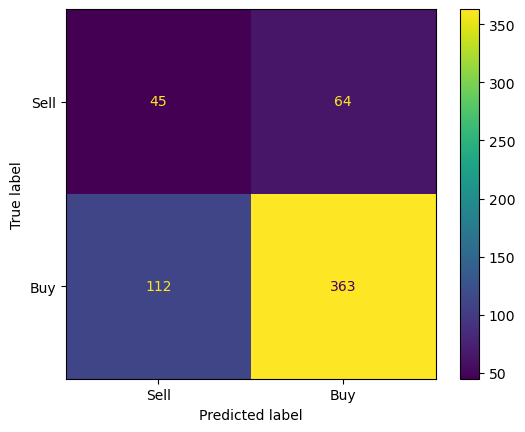

In [314]:
rfc_pipeline.fit(X_train, y_train)
y_pred = rfc_pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f1)
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
ConfusionMatrixDisplay(cm, display_labels= ['Sell','Buy']).plot()

Hyper Parameter Tuning

In [308]:
rfc_params = {'random_forest__max_depth': [5,10,15,20,25], 'random_forest__n_estimators': [45,50,55,60,65]}

In [309]:
gs = GridSearchCV(rfc_pipeline, rfc_params, cv = 5, scoring = 'f1', verbose = 1)
gs.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=7)),
                                       ('random_forest',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'random_forest__max_depth': [5, 10, 15, 20, 25],
                         'random_forest__n_estimators': [45, 50, 55, 60, 65]},
             scoring='f1', verbose=1)

In [310]:
gs.best_params_

{'random_forest__max_depth': 20, 'random_forest__n_estimators': 55}

In [311]:
gs.best_score_

0.7655829371001845

Updating Parameters

In [312]:
rfc = RandomForestClassifier(max_depth = 20, n_estimators = 55, random_state = 42)
rfc_pipeline = Pipeline([('smote', smt),('scaler', ss),('random_forest', rfc)])

0.7178026924980342


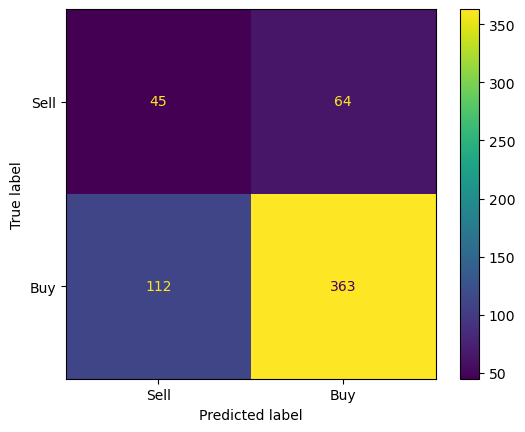

In [313]:
rfc_pipeline.fit(X_train, y_train)
y_pred = rfc_pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred, average = 'weighted')
print(f1)
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
ConfusionMatrixDisplay(cm, display_labels= ['Sell','Buy']).plot()

### Convolutional Neural Network

Preprocessing Data

In [315]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

In [316]:
# Preparing Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE
smt = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)

# PCA
pca = PCA(n_components = 5)
X_train_ready = pca.fit_transform(X_train_resampled)
X_test_ready = pca.transform(X_test_scaled)

# Reshaping Data
X_train_ready = X_train_resampled.values.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
X_test_ready = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Map labels to non-negative integers
# Encode labels
y_train_encoded = to_categorical(y_train_resampled)
y_test_encoded = to_categorical(y_test)

c:\Users\cnade\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [317]:
X_test_ready.shape

(584, 7, 1)

In [318]:
y_train_encoded.shape

(2116, 2)

In [319]:
# Creating F1 Score
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [320]:
# Creating Neural Network Function
def create_classification_model(dropout_rate=0.2, l2_weight=0.001, batch_size=32, epochs=10):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_ready.shape[1],1), kernel_regularizer=l2(l2_weight)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_weight)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2, activation='softmax', kernel_regularizer=l2(l2_weight)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])
    return model

In [324]:
model = create_classification_model()
model.fit(X_train_ready, y_train_encoded, epochs=25, validation_data=(X_test_ready, y_test_encoded))

Epoch 1/25
19/19 [==============================] - 3s 30ms/step - loss: 0.7471 - f1_m: 0.7566 - val_loss: 0.6526 - val_f1_m: 0.8207
Epoch 2/25
19/19 [==============================] - 0s 11ms/step - loss: 0.6299 - f1_m: 0.8109 - val_loss: 0.6008 - val_f1_m: 0.8207
Epoch 3/25
19/19 [==============================] - 0s 11ms/step - loss: 0.5949 - f1_m: 0.8010 - val_loss: 0.5777 - val_f1_m: 0.8207
Epoch 4/25
19/19 [==============================] - 0s 10ms/step - loss: 0.5755 - f1_m: 0.8158 - val_loss: 0.5624 - val_f1_m: 0.8207
Epoch 5/25
19/19 [==============================] - 0s 11ms/step - loss: 0.5589 - f1_m: 0.8191 - val_loss: 0.5473 - val_f1_m: 0.8224
Epoch 6/25
19/19 [==============================] - 0s 11ms/step - loss: 0.5564 - f1_m: 0.8158 - val_loss: 0.5366 - val_f1_m: 0.8207
Epoch 7/25
19/19 [==============================] - 0s 11ms/step - loss: 0.5448 - f1_m: 0.8224 - val_loss: 0.5277 - val_f1_m: 0.8240
Epoch 8/25
19/19 [==============================] - 0s 11ms/step - lo

## Modeling for Expected Growth Rate

In [402]:
modeling_growth_df = stock_data[['Ticker', 'TotalRevenue', 'NormEBITDA', 'ReturnOnAssets','ChangeNormEBITDA','ChangeRevenue','OperatingCashFlow','ChangeOCF','ExpectedGrowthRate']]
modeling_growth_df.set_index('Ticker', inplace = True)

In [403]:
X = modeling_growth_df.drop(['ExpectedGrowthRate'], axis = 1)
y = modeling_growth_df['ExpectedGrowthRate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= 42)

#### Linear Regression Baseline Model

In [404]:
linreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Fit pipeline to training data
linreg_pipeline.fit(X_train, y_train)

# Evaluate pipeline on testing data
y_pred = linreg_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Root mean squared error:', rmse)

Root mean squared error: 0.39931552858722663


In [385]:
y_pred_mapped = np.where(y_pred < 0.1, 0, 1)
y_test_mapped = np.where(y_test < 0.1, 0, 1)

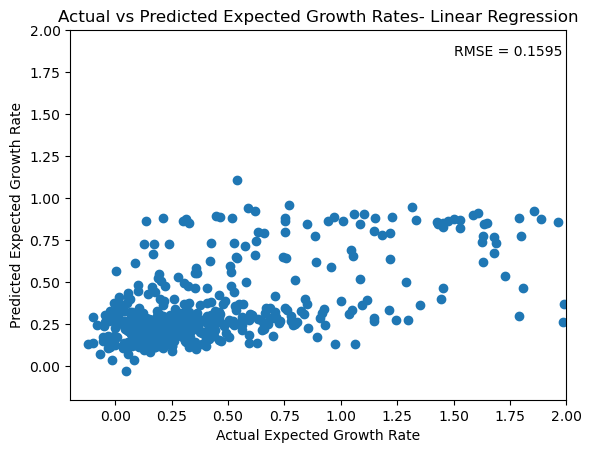

In [422]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Expected Growth Rate')
plt.ylabel('Predicted Expected Growth Rate')
plt.title('Actual vs Predicted Expected Growth Rates- Linear Regression')
plt.text(1.5,1.85, 'RMSE = 0.1595')
plt.xlim(-0.2, 2)
plt.ylim(-0.2, 2)

plt.show()

0.8963133640552996


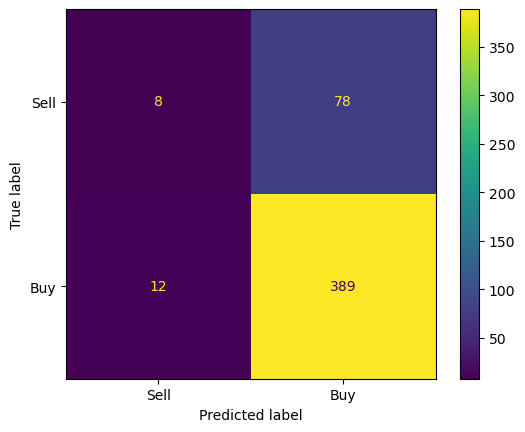

In [330]:
print(f1_score(y_test_mapped, y_pred_mapped))
cm = confusion_matrix(y_true = y_test_mapped, y_pred = y_pred_mapped)
ConfusionMatrixDisplay(cm, display_labels= ['Sell','Buy']).plot()

### Neural Network P2- A Feedforward Neural Network

In [406]:
# Preparing Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshaping Data
X_train_ready = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_ready = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

In [407]:
def create_continuous_model(dropout_rate=0.2, l2_weight=0.001, batch_size=32, epochs=10):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_ready.shape[1],1), kernel_regularizer=l2(l2_weight)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_weight)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear', kernel_regularizer=l2(l2_weight)))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

In [408]:
model = create_continuous_model()
model.fit(X_train_ready, y_train, epochs = 24, batch_size = 32, validation_data=[X_test_ready, y_test])

Epoch 1/24
46/46 [==============================] - 2s 13ms/step - loss: 0.3408 - mse: 0.2057 - val_loss: 0.2705 - val_mse: 0.1456
Epoch 2/24
46/46 [==============================] - 0s 6ms/step - loss: 0.2430 - mse: 0.1265 - val_loss: 0.2411 - val_mse: 0.1328
Epoch 3/24
46/46 [==============================] - 0s 6ms/step - loss: 0.2239 - mse: 0.1222 - val_loss: 0.2290 - val_mse: 0.1338
Epoch 4/24
46/46 [==============================] - 0s 6ms/step - loss: 0.2051 - mse: 0.1153 - val_loss: 0.2174 - val_mse: 0.1329
Epoch 5/24
46/46 [==============================] - 0s 6ms/step - loss: 0.1929 - mse: 0.1130 - val_loss: 0.2040 - val_mse: 0.1286
Epoch 6/24
46/46 [==============================] - 0s 7ms/step - loss: 0.1829 - mse: 0.1113 - val_loss: 0.2004 - val_mse: 0.1326
Epoch 7/24
46/46 [==============================] - 0s 8ms/step - loss: 0.1774 - mse: 0.1129 - val_loss: 0.1888 - val_mse: 0.1277
Epoch 8/24
46/46 [==============================] - 0s 7ms/step - loss: 0.1714 - mse: 0.1

In [409]:
y_pred = model.predict(X_test_ready)

16/16 [==============================] - 0s 2ms/step


In [410]:
y_pred = pd.Series(y_pred.flatten())

In [411]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Root mean squared error:', rmse)

Root mean squared error: 0.36322525620112756


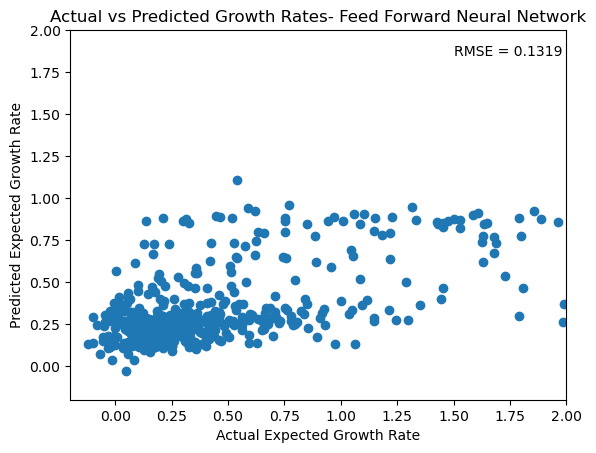

In [423]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Expected Growth Rate')
plt.ylabel('Predicted Expected Growth Rate')
plt.title('Actual vs Predicted Growth Rates- Feed Forward Neural Network')
#plt.legend(['RMSE: {:.4f}'.format(mse)])
plt.xlim(-0.2, 2)
plt.ylim(-0.2, 2)
plt.text(1.5,1.85, 'RMSE = 0.1319')
plt.show()

In [357]:
y_pred_mapped = np.where(y_pred < 0.1, 0, 1)
y_test_mapped = np.where(y_test < 0.1, 0, 1)

0.8234086242299795


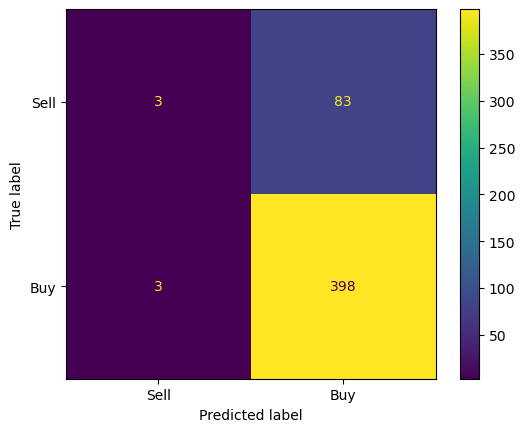

In [358]:
print(accuracy_score(y_test_mapped, y_pred_mapped))
cm = confusion_matrix(y_true = y_test_mapped, y_pred = y_pred_mapped)
ConfusionMatrixDisplay(cm, display_labels= ['Sell','Buy']).plot()